In [1]:
import os
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import emcee

from SourceData import SourceData
from modules import MCMCFunctions, GWFunctions

import corner

class EmceeSampler(SourceData):
    """Compute posterior probability densities for
    quasinormal modes in the frequency domain."""

    def __init__(self, modes_data:list, modes_model:list, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.modes_data = modes_data
        self.modes_model = modes_model
        self.inject_data(self.modes_data) # construct self.data

        self.fit_coeff = {}
        for mode in self.modes_model:
            self.fit_coeff[mode] = self.transf_fit_coeff(mode)

        self.df_a_omegas = {}
        for mode in self.modes_model:
            self.df_a_omegas[mode] = self.create_a_over_M_omegas_dataframe(mode)

    def run_sampler(self):
        """Compute posterior density function of the parameters.
        """
        self._prior_and_logpdf()
        self._theta_true()
        ndim = len(self.theta_true)
        self.nwalkers = 100
        self.nsteps = 1000
        self.thin = 30
#         self.nwalkers = 30
#         self.nsteps = 200
#         self.thin = 15

        # pos = self.prior_transform(np.random.rand(self.nwalkers, ndim))
        pos = (self.theta_true + 1e-4 * np.random.randn(self.nwalkers, ndim))

        sampler = emcee.EnsembleSampler(self.nwalkers, ndim, self.log_pdf)
        sampler.run_mcmc(pos, self.nsteps, progress=True)
        self.samples = sampler.get_chain()
        self.flat_samples = sampler.get_chain(discard=int(self.nsteps/2), thin=self.thin, flat=True)

        # corner.corner(self.flat_samples, truths=self.theta_true, labels = self.theta_labels)
        # plt.show()

    def prior_transform(self, hypercube):
        """Transforms the uniform random variable 'hypercube ~ Unif[0., 1.)'
        to the parameter of interest 'theta ~ Unif[true/100,true*100]'."""
        transform = lambda a, b, x: a + (b - a) * x
        cube = np.array(hypercube)
        for i in range(len(self.modes_model)):
            cube[0+4*i] = transform(0.0, 10,cube[0 + 4*i])
            cube[1+4*i] = transform(0.0, 2*np.pi,cube[1 + 4*i])
            cube[2+4*i] = transform(0.9, 1,cube[2 + 4*i])
            cube[3+4*i] = transform(0.0, 0.9999,cube[3 + 4*i])
        return cube
    def _prior_and_logpdf(self):
        """Define priors for the model
        """
        
        limit_min = []
        limit_max = []
        for i in range(len(self.modes_model)):
            limit_min.extend([0.,
                0.,
                # 0.1,
                self.final_mass/10,
                0,
                ])
            limit_max.extend([
                10.,
                2*np.pi,
                # 10,
                self.final_mass*10,
                0.9999,
                ])

        self.prior_function = lambda theta: MCMCFunctions.noninfor_log_prior(theta, limit_min, limit_max)
        self.log_pdf = lambda theta: MCMCFunctions.log_probability_qnm(
            theta,
            self.prior_function,
            self.model_function,
            self.data,
            self.detector["freq"],
            self.detector["psd"]
            )

    def _theta_true(self):
        """Generate a list of the true injected parameters.
        """
        self.theta_true = []
        self.theta_labels = []

        for mode in self.modes_model:
            self.theta_true.extend(
                [self.qnm_modes[mode].amplitude,
                float(self.qnm_modes[mode].phase),
                # self.mass_final,
                self.final_mass,
                self.final_spin])
            self.theta_labels.extend([
                r"$A_{{{0}}}$".format(mode),
                r"$\phi_{{{0}}}$".format(mode),
                r"$M_{{{0}}}$".format(mode),
                r"$a_{{{0}}}$".format(mode),
            ])
        self.theta_true = tuple(self.theta_true)


    def model_function(self, theta:list):
        """Generate waveform model function of QNMs.

        Parameters
        ----------
        theta : array_like
            Model parameters.

        Returns
        -------
        function
            Waveform model as a function of parameters theta.
        """
        h_model = 0
        for i in range(len(self.modes_model)):
            A, phi, M, a = theta[0 + 4*i: 4 + 4*i]
            M = M/self.mass_initial
            omega_r, omega_i = self.transform_mass_spin_to_omegas(
                M,
                a,
                self.df_a_omegas[self.modes_model[i]],
                # self.modes_model[i],
                # self.fit_coeff[self.modes_model[i]]
            )
            h_model += self.time_convert*self.amplitude_scale*GWFunctions.compute_qnm_fourier(
                self.detector["freq"]*self.time_convert, A, phi, omega_r, omega_i, 
                part = "real", convention = self.ft_convention)
        return h_model




In [2]:
np.random.seed(1234)
m_f = 500
z = 0.1
q = 1.5
detector = "LIGO"
# modes = ["(2,2,0)"]
modes = ["(2,2,0)", "(2,2,1) I"]
# modes = ["(2,2,0)", "(4,4,0)"]
# modes = ["(2,2,0)", "(3,3,0)"]
# modes_model = ["(2,2,0)"]
modes_model = ["(2,2,0)", "(2,2,1) I"]
# modes_model = ["(2,2,0)", "(4,4,0)"]
# modes_model = ["(2,2,0)", "(3,3,0)"]
teste = EmceeSampler(modes, modes_model, detector, m_f, z, q, "FH")
teste.run_sampler()

100%|██████████| 1000/1000 [01:56<00:00,  8.62it/s]


In [3]:
import pandas as pd
df = pd.DataFrame(teste.flat_samples, columns=teste.theta_labels)
list(df)

['$A_{(2,2,0)}$',
 '$\\phi_{(2,2,0)}$',
 '$M_{(2,2,0)}$',
 '$a_{(2,2,0)}$',
 '$A_{(2,2,1) I}$',
 '$\\phi_{(2,2,1) I}$',
 '$M_{(2,2,1) I}$',
 '$a_{(2,2,1) I}$']

In [4]:
df1 = df[['$a_{(2,2,0)}$','$M_{(2,2,0)}$']].copy()
df1.columns = ['spin', 'mass']
df1['mode'] = '(2,2,0)'
df2 = df[['$a_{(2,2,1) I}$','$M_{(2,2,1) I}$']].copy()
df2.columns = ['spin', 'mass']
df2['mode'] = '(2,2,1)'
df2
df_plot = pd.concat([df1, df2])
df_plot

,spin,mass,mode
0,0.707767,516.239938,"(2,2,0)"
1,0.695313,510.862481,"(2,2,0)"
2,0.678085,504.487134,"(2,2,0)"
3,0.693918,509.360777,"(2,2,0)"
4,0.695978,510.953510,"(2,2,0)"
...,...,...,...
1595,0.701428,514.554571,"(2,2,1)"
1596,0.665414,509.751128,"(2,2,1)"
1597,0.686212,512.877250,"(2,2,1)"
1598,0.638650,482.963967,"(2,2,1)"


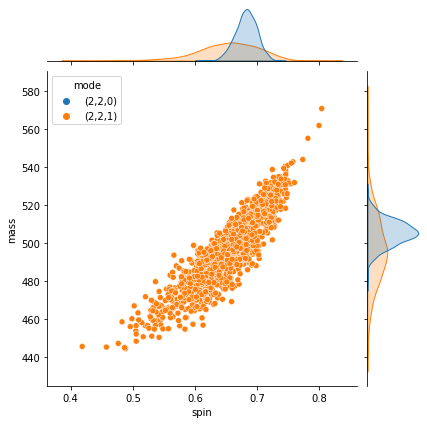

In [5]:
fig = sns.jointplot(data = df_plot, x = 'spin', y = 'mass', hue = 'mode',)
plt.show()

In [84]:

from scipy.stats import gaussian_kde
from matplotlib import transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib as mpl

def pair_plot(x:list, y:list, x_true:float, y_true:float, plot_color:str, levels = [90], style="both", clabel=False):
    # compute density
    k = gaussian_kde(np.vstack([x, y]))
    
    # create grid
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    #set zi to 0-1 scale
    zi = (zi-zi.min())/(zi.max() - zi.min())
    zi =zi.reshape(xi.shape)
    
#     # start plot figure
#     fig, axScatter = plt.subplots(figsize=(10, 10))

    # the scatter plot:
#     axScatter.scatter(x, y, alpha = 0.1, color = plot_color, marker='p')
    if style=='both':
        axScatter.scatter(x_true, y_true, marker = '+', color = 'k')
        axScatter.axvline(x = x_true, lw=2, ls=':', color = 'k', alpha=.5)
        axScatter.axhline(y = y_true, lw=2, ls=':', color = 'k', alpha=.5)
    elif style=='point':
        axScatter.scatter(teste.final_spin, teste.final_mass, marker = '+', color = 'k')
    elif style=='lines':
        axScatter.axvline(x = x_true, lw=2, ls=':', color = 'k', alpha=.5)
        axScatter.axhline(y = y_true, lw=2, ls=':', color = 'k', alpha=.5)
        
    #set up plot
    origin = 'lower'
    lvls = []
    for level in levels:
        lvls.append(1 - level/100)

    CS = axScatter.contour(xi, yi, zi,levels = lvls,
              colors=(plot_color,),
              linewidths=(3,),
              origin=origin)
    
    cmap = mpl.colors.ListedColormap(['white',plot_color])
    lvls.append(1)
    axScatter.contourf(xi, yi, zi,levels = lvls,
              cmap = cmap,
              alpha = 0.3,
              origin=origin)
    
    if clabel == True:
        axScatter.clabel(CS, fmt=levels, colors = plot_color)
        axScatter.ticklabel_format(axis='y', style='sci', scilimits=(0,0))


#     # create new axes on the right and on the top of the current axes
#     # The first argument of the new_vertical(new_horizontal) method is
#     # the height (width) of the axes to be created in inches.
#     divider = make_axes_locatable(axScatter)
#     axHistx = divider.append_axes("top", 1.5, pad=0., sharex=axScatter)
#     axHisty = divider.append_axes("right", 1.5, pad=0., sharey=axScatter)

#     # make some labels invisible
#     # axHistx.axis('off')
#     axHistx.xaxis.set_tick_params(labelbottom=False)
#     axHistx.set_yticks([])

#     axHisty.set_xticks([])
#     axHisty.yaxis.set_tick_params(labelleft=False)

    # axHistx.hist(x, bins = 100, density = True, alpha = 0.3)
    xx = np.linspace(min(x), max(x),100)
    axHistx.fill(xx,gaussian_kde(x)(xx), color = plot_color, alpha = 0.3)
    axHistx.plot(xx,gaussian_kde(x)(xx), color = plot_color, linewidth = 3)
    axHistx.axvline(x = np.percentile(x, 5), lw=3, ls='--', color = plot_color)
    axHistx.axvline(x = np.percentile(x, 95), lw=3, ls='--', color = plot_color)


    # first of all, the base transformation of the data points is needed
    base = plt.gca().transData
    rot = transforms.Affine2D().rotate_deg(-90)

    # axHisty.hist(y, bins=100, orientation='horizontal', alpha = 0.2)
    yy = np.linspace(min(y), max(y),100)
    axHisty.fill(-yy,gaussian_kde(y)(yy), color = plot_color, alpha = 0.3, transform= rot + base)
    axHisty.plot(-yy, gaussian_kde(y)(yy), color = plot_color, linewidth = 3, transform= rot + base, label = "teasdasdasdasdsste")
    axHisty.axhline(y = np.percentile(y, 5), lw=3, ls='--', color = plot_color)
    axHisty.axhline(y = np.percentile(y, 95), lw=3, ls='--', color = plot_color)
    


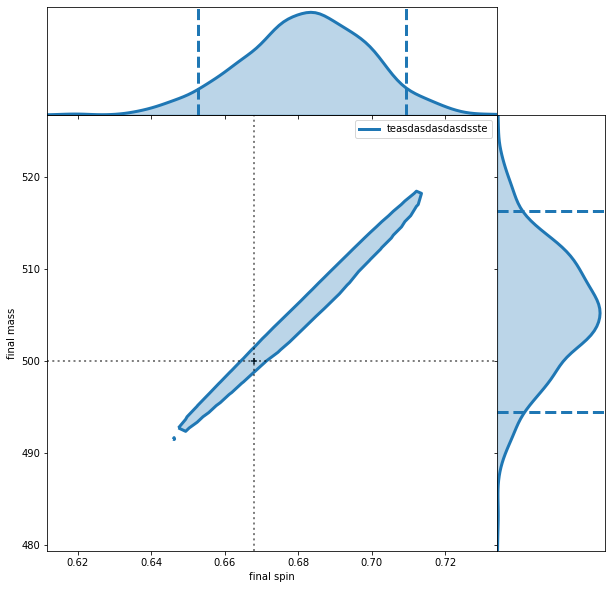

In [85]:

modes = ["(2,2,0)"]#, "(2,2,1) I"]
x_true, y_true = teste.final_spin, teste.final_mass

# start plot figure
fig, axScatter = plt.subplots(figsize=(10, 10))

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.5, pad=0., sharex=axScatter)
axHisty = divider.append_axes("right", 1.5, pad=0., sharey=axScatter)

# make some labels invisible
# axHistx.axis('off')
axHistx.xaxis.set_tick_params(labelbottom=False)
axHistx.set_yticks([])

axHisty.set_xticks([])
axHisty.yaxis.set_tick_params(labelleft=False)


colors = {modes[0]: 'tab:blue'}#, modes[1]: 'tab:orange'}
for mode in reversed(modes):
    # import data
    x = df[r"$a_{{{0}}}$".format(mode)].values
    y = df[r"$M_{{{0}}}$".format(mode)].values
    pair_plot(x, y, x_true, y_true, plot_color= colors[mode])

axHistx.set_ylim(bottom = 0)    
axHisty.set_xlim(left = 0)
axScatter.set_xlabel('final spin')
axScatter.set_ylabel('final mass')
plt.legend(bbox_to_anchor=(0,1))

plt.show()
    

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


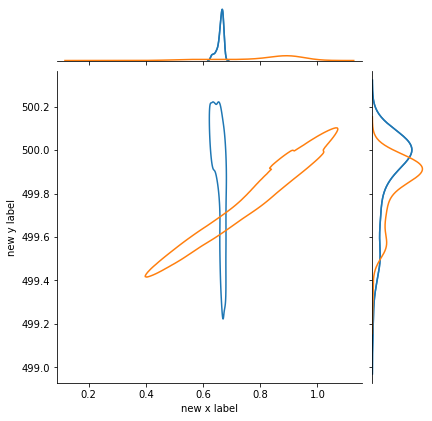

In [73]:
fig = sns.jointplot(data = df, x = '$a_{(2,2,0)}$', y = '$M_{(2,2,0)}$', kind = 'kde', levels = 2, color='tab:blue',)
fig.x = df['$a_{(2,2,1) I}$']
fig.y = df['$M_{(2,2,1) I}$']
g = fig.plot_joint(sns.kdeplot, levels = 2, color = 'tab:orange')
sns.kdeplot(df['$a_{(2,2,0)}$'], ax=g.ax_marg_x, legend=False, color='tab:blue')
sns.kdeplot(df['$a_{(2,2,1) I}$'], ax=g.ax_marg_x, legend=False, color = 'tab:orange')
sns.kdeplot(df['$M_{(2,2,0)}$'], ax=g.ax_marg_y, vertical=True, legend=False, color='tab:blue')
sns.kdeplot(df['$M_{(2,2,1) I}$'],  ax=g.ax_marg_y, vertical=True, legend=False, color = 'tab:orange')


fig.ax_joint.set_xlabel('new x label')
fig.ax_joint.set_ylabel('new y label')
plt.show()

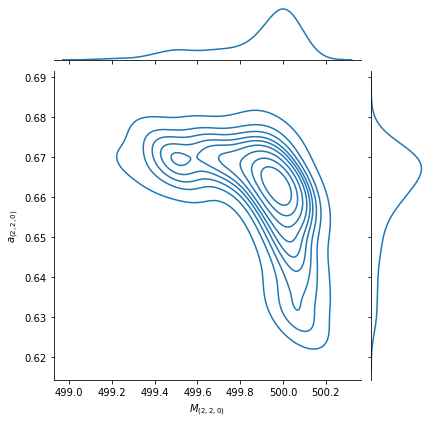

In [74]:
fig = sns.jointplot(data = df, x = '$M_{(2,2,0)}$', y = '$a_{(2,2,0)}$', kind = 'kde')


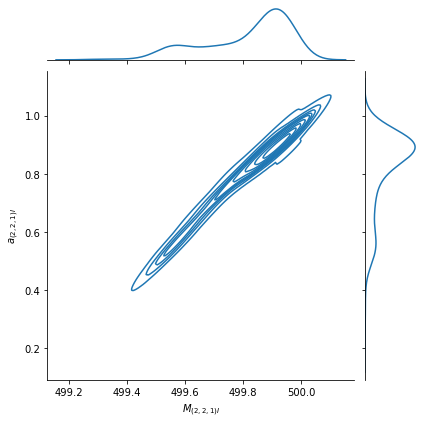

In [75]:
fig = sns.jointplot(data = df, x = '$M_{(2,2,1) I}$', y = '$a_{(2,2,1) I}$', kind = 'kde')
